The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl
!pip install git+https://github.com/d2l-ai/d2l-tvm


# Vector Add

:label:`ch_vector_add_cpu`


In this section, we will optimize the vector add defined in :numref:`ch_vector_add` on CPU.

## Setup

In [1]:
%matplotlib inline
import d2ltvm
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm

We first define reusable plot functions to draw multiple lines, which generalize the plot function defined in :numref:`ch_call_overhead`.

In [2]:
# Save to the d2ltvm package.
def plot(X, Y, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear', fmts=None,
         figsize=(4.5, 3)):
    """Plot multiple lines"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    axes = plt.gca()
    X, Y = np.array(X), np.array(Y)
    if X.shape != Y.shape: X = [X] * len(Y)
    if not fmts: fmts = ['-'] * len(X)
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()

# Save to the d2ltvm package
def plot_gflops(sizes, gflops, legend, xlabel='Size'):
    d2ltvm.plot(sizes, gflops, xlabel=xlabel, ylabel='GFLOPS',
             xscale='log', yscale='log',
             legend=legend, fmts=['--']*(len(gflops)-1)+['-'])

Then we benchmark the performance of NumPy as our baseline. We show the vector size vs measured [GFLOPS](https://en.wikipedia.org/wiki/FLOPS), giga-floating point operations per second, in the following diagram.

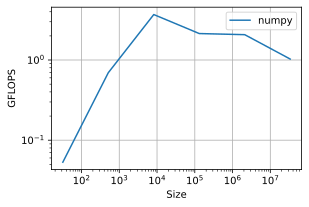

In [3]:
sizes = 2**np.arange(5, 29, 4)
np_add = lambda n: timeit.Timer(setup='import numpy as np\n'
                                'import d2ltvm\n'
                                'a, b, c = d2ltvm.get_abc(%d)' % n,
                                stmt='np.add(a, b, out=c)')
exe_times = [d2ltvm.bench_workload(np_add(n).timeit) for n in sizes]
np_gflops = sizes / 1e9 / np.array(exe_times)
plot_gflops(sizes, [np_gflops], ['numpy'])

As we can see that the performance first increases with the vector length, which is due to the system overhead domination when the workload is small. The performance then decreases when we cannot fit all data into the cache.

## Default Schedule

In the following code block, we define a reusable method to benchmark TVM performance. It accepts three arguments: 1) a `func` which returns the schedule and its corresponding symbolic tensor arguments; 2) the size list specifying a number of the vector lengths; and 3) the machine target which is CPU-related for this chapter and will be GPU-related in the next chapter.

In [4]:
# Save to the d2ltvm package.
def bench_vector_add_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.context(target, 0)
        a, b, c = d2ltvm.get_abc(n, lambda x: tvm.nd.array(x, ctx=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return sizes / 1e9 / np.array(times)

The default schedule is a plain one-level for-loop program.

In [5]:
def default(n):
    A, B, C = d2ltvm.vector_add(n)
    s = tvm.create_schedule(C.op)
    return s, (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

produce c {
  for (i, 0, 64) {
    c[i] = (a[i] + b[i])
  }
}



Remember in :numref:`ch_cpu_arch` we found that our CPU supports AVX-512, we pass `-mcpu=skylake-avx512` to LLVM so that it can generate AVX-512 instructions if possible. In the following codes, we print a few lines of generated LLVM code.

In [6]:
target = 'llvm -mcpu=skylake-avx512'
mod = tvm.build(s, args, target)
print(mod.get_source()[:500])

; ModuleID = 'default_function'
source_filename = "default_function"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-pc-linux-gnu"

%0 = type { i8*, %1, i32, %2, i64*, i64*, i64 }
%1 = type { i32, i32 }
%2 = type { i8, i8, i16 }

@__TVMAPISetLastError = linkonce dllexport local_unnamed_addr global void (i8*)* null, align 8
@.str = private constant [69 x i8] c"Assert fail: (num_args == 3), default_function: num_args should be 3\00", align 1
@.str.1 = private co


You may find it not quite readable if you are not familiar with LLVM IR. But you don't need to worry much as in most cases, only reading the C-like pseudo code is sufficient to study the performance. Now let's benchmark the default schedule.

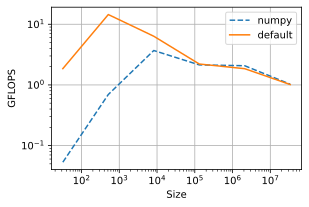

In [7]:
default_gflops = bench_vector_add_tvm(default, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

When the vector size is small, the default scheduling outperforms NumPy, which means that in this method the function call overhead of TVM is smaller than NumPy. It's not surprising to find the performance degrades when increasing the vector size as the data cannot fit into the last level cache.

## Parallelization

One important optimization that is not enabled by default is thread-level parallelization. The vector add operator is an [embarrassingly parallel workload](https://en.wikipedia.org/wiki/Embarrassingly_parallel), we can just change the for-loop into a parallel for-loop. In TVM, we first obtain the scheduler for the output symbol `C` by `s[C]`, and then impose the parallelization of the computation to its first axis, which is `C.op.axis[0]`.

In [8]:
def parallel(n):
    s, (A, B, C) = default(n)
    # add thread-level parallelism
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

produce c {
  parallel (i, 0, 64) {
    c[i] = (a[i] + b[i])
  }
}



We can see that `for` is changed to `parallel` in the above pseudo codes. It means that the iterations could be executed in parallel by multiple threads.
A typical implementation on a system with $t$ CPU cores is we first create $t$ threads with one thread for each core, then thread $i$ will execute blocks $j$ if `j % t = i`. All these threads will run simultaneously  on their exclusive cores to achieve parallelization, and come back to retrieve another block to execute after finishing one. This is often called the [round-robin scheduling](https://en.wikipedia.org/wiki/Round-robin_scheduling), which works well if each thread runs at the same speed and every iteration has a roughly same workload. TVM's thread-level parallelization implementation is a special case of round-robin, which evenly divides the to-be-parallelized $n$-length loop into $t$ blocks. Therefore, each thread only needs to process one block. 
Furthermore, the TVM runtime binds each working thread to a disjoint physical core to avoid resource contention and thread migration overhead.
There are other thread-level parallelization schemes such as the more dynamic [consumer-producer scheduling](https://en.wikipedia.org/wiki/Producer–consumer_problem).

Then we check the parallelization of vectorization and plot the comparison diagram via the following code block.

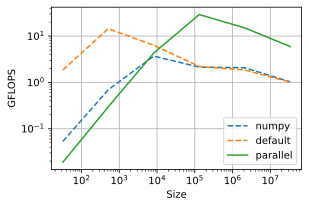

In [9]:
parallel_gflops = bench_vector_add_tvm(parallel, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops],
     ['numpy', 'default', 'parallel'])

Comparing the results we obtained before, parallelization significantly improves the performance when the workloads are large, e.g. vector lengths beyond $10^4$. However, the parallelization overhead impact the performance for small workloads, where single thread is even faster. The performance drops at a larger size as multi-core comes in play, leading to a larger amount of L2 cache in total.

## Vectorization

A single core may have SIMD units to run multiple arithmetic operations at the same time as we saw in :numref:`ch_cpu_arch`. Although one iteration in the above loop only has a single add operation, we can explicitly allocate more operations within an iteration, and ask the compiler to use SIMD instructions to process them.

The way to do it is first splitting the one-level for-loop into a two-level nested for-loop using a `factor`. The inner loop consists of `factor` original iterations that will be grouped together accordingly to execute in SIMD instructions on a core. And iterations in the outer loop still run in parallel.

In [10]:
def vectorized(n):
    s, (A, B, C) = default(n)
    outer, inner = s[C].split(C.op.axis[0], factor=8)
    s[C].parallel(outer)
    s[C].vectorize(inner)
    return s, (A, B, C)

s, args = vectorized(64)
print(tvm.lower(s, args, simple_mode=True))

produce c {
  parallel (i.outer, 0, 8) {
    c[ramp((i.outer*8), 1, 8)] = (a[ramp((i.outer*8), 1, 8)] + b[ramp((i.outer*8), 1, 8)])
  }
}



We can see that the outer for-loop is reduced to 8 iterations, while the inner for-loop is vectorized by `ramp` with a stride of 1 and width of 8. The definition of `ramp` is inherited from [Halide](https://halide-lang.org/docs/struct_halide_1_1_internal_1_1_ramp.html).

Again, we check the performance of vectorization and plot the comparison diagram via the following code block.

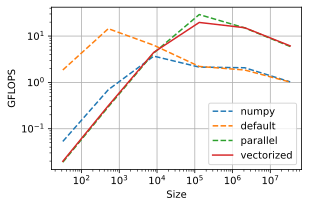

In [11]:
vectorized_gflops = bench_vector_add_tvm(vectorized, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops, vectorized_gflops],
     ['numpy', 'default', 'parallel', 'vectorized'])

The performance of the vectorized version is almost as the plain parallelization version. It's partially because the vector add is bottlenecked by memory bandwidth instead of computation, while SIMD only helps the latter. We will see it helps more on computation intensive workloads such as matrix multiplication later.

## Summary

- The default scheduling generates naive single-thread CPU program.
- Parallelization improves performance for large workloads.
- We can split a for-loop and then vectorize the inner loop if the system supports SIMD.